In [98]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier
import math
import pickle
import json
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import os

from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.ensemble import VotingClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
file = 'FMP/AA/2021/2021_3.json'
with open(file) as train_file:
    dict_ = json.load(train_file)

In [60]:
df = pd.json_normalize(dict_)

In [61]:
df

,symbol,quarter,year,date,content
0,AA,3,2021,2021-10-14 20:56:08,Operator: Good afternoon and welcome to the Al...


In [5]:
type(df['content'][0])

str

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [8]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91979\AppData\Roaming\nltk_data...


True

In [9]:
sia = SentimentIntensityAnalyzer()

In [19]:
def senti_score(text):
    neg = sia.polarity_scores(text)['neg']
    pos = sia.polarity_scores(text)['pos']
    if pos>=neg :
        polarity = 'Positive'
    else :
        polarity = 'Negative'
    score = (pos)/(pos + neg)
    
    return score, polarity

In [20]:
senti_score(df['content'][0])

(0.937888198757764, 'Positive')

In [69]:
import os

name = []
scores = []
polarity = []


# Specify the main directory to search
directory = "FMP"

# Loop through each subdirectory in the main directory
for subdir in tqdm(os.listdir(directory)):
    # Construct the full path to the subdirectory
    subdir_path = os.path.join(directory, subdir)

    # Check that the path is a directory
    if os.path.isdir(subdir_path):
        # Loop through each subdirectory in the subdirectory
        for subsubdir in os.listdir(subdir_path):
            # Construct the full path to the sub-subdirectory
            subsubdir_path = os.path.join(subdir_path, subsubdir)

            # Check that the path is a directory
            if os.path.isdir(subsubdir_path):
                # Get a list of all files in the sub-subdirectory
                files = os.listdir(subsubdir_path)

                # Sort the files by modification time
                files.sort(key=lambda x: os.path.getmtime(os.path.join(subsubdir_path, x)))

                # Get the last file in the sorted list
                last_file = os.path.join(subsubdir_path, files[-1])

                # Do some action on the last file, for example, print its name
                file_path = last_file.replace("\\", "/")
                
                with open(file_path) as train_file:
                    dict_ = json.load(train_file)
                
                    df = pd.json_normalize(dict_)
                
                    a,b = senti_score(df['content'][0])
                
                    scores.append(a)
                    polarity.append(b)
                    name.append(df['symbol'])
                
            break

100%|██████████| 4218/4218 [16:50<00:00,  4.17it/s]


In [95]:
d = pd.DataFrame({'Name': name,
                  'Score for last financial quarter': scores,
                  'Polarity': polarity}, index=None)
    
d

,Name,Score for last financial quarter,Polarity
0,AA,0.510215,Positive
1,AACG,0.570732,Positive
2,AADI,0.498168,Negative
3,AAIC,0.552174,Positive
4,AAL,0.532682,Positive
...,...,...,...
3679,ZUMZ,0.438571,Negative
3680,ZVO,0.477338,Negative
3681,ZY,0.539706,Positive
3682,ZYME,0.502349,Positive


In [97]:
d.to_csv('Sentiment_Score.csv',index=False)

# Price Prediction

In [1]:
cd prices

C:\Users\91979\Desktop\Jup_NoteBks\TechSoc\Arcana Hack 2\prices


In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is 08D2-4DA2

 Directory of C:\Users\91979\Desktop\Jup_NoteBks\TechSoc\Arcana Hack 2\prices

04/15/2023  12:20 PM    <DIR>          .
04/15/2023  12:20 PM    <DIR>          ..
04/15/2023  02:30 AM        54,239,264 bq-results-20230414-205924-1681505974800.csv
04/15/2023  02:33 AM        94,142,936 bq-results-20230414-210045-1681506054580.csv
04/15/2023  02:35 AM       179,041,880 bq-results-20230414-210330-1681506224804.csv
04/15/2023  02:38 AM       253,208,892 bq-results-20230414-210455-1681506313730.csv
04/15/2023  02:40 AM       338,092,824 bq-results-20230414-210630-1681506404411.csv
04/15/2023  03:22 AM       441,054,096 bq-results-20230414-210836-1681506532204.csv
04/15/2023  08:08 AM       365,714,809 bq-results-20230414-214948-1681509023746.csv
               7 File(s)  1,725,494,701 bytes
               2 Dir(s)   2,562,015,232 bytes free


In [3]:
cd ..

C:\Users\91979\Desktop\Jup_NoteBks\TechSoc\Arcana Hack 2


In [15]:
directory = 'prices'

# get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# create an empty list to hold the dataframes
dfs = []

# loop through the CSV files and read them into dataframes
for file in csv_files:
    path = os.path.join(directory, file)
    df = pd.read_csv(path)
    dfs.append(df)

# stack the dataframes vertically into a single dataframe
stacked_df = pd.concat(dfs, axis=0, ignore_index=True)

# print the stacked dataframe
print(stacked_df)

                  ds   symbol      close     volume
0         1992-02-28      AFL   2.000000   609000.0
1         1992-02-03      WDC   2.000000   250200.0
2         1992-02-03     FACO   2.000000    18600.0
3         1992-02-21     FICO   2.000000   783000.0
4         1992-02-03    MOG-A   2.000000     2363.0
...              ...      ...        ...        ...
59955915  2020-07-30  0329.HK   0.580000  1168000.0
59955916  2020-07-30     NYMX   3.180000    76258.0
59955917  2020-07-31    GDNSF   0.592500    84857.0
59955918  2020-07-31     MUEL  26.145648      550.0
59955919  2020-07-31     CYDY   4.974000  8231596.0

[59955920 rows x 4 columns]


In [17]:
grouped = stacked_df.groupby('symbol')

# Iterate through the groups and create new dataframes with names based on the group name
for name, group in tqdm(grouped):
    new_df_name = f"{name.upper()}_df"
    print(new_df_name)
    globals()[new_df_name] = group.reset_index(drop=True)

  2%|▏         | 300/17445 [00:34<23:05, 12.37it/s]  

0003.HK_df
0004.HK_df
0007.HK_df
0008.HK_df
0009.HK_df
0010.HK_df
0012.HK_df
0014.HK_df
0018.HK_df
0020.HK_df
0021.HK_df
0022.HK_df
0023.HK_df
0025.HK_df
0026.HK_df
0028.HK_df
0029.HK_df
0030.HK_df
0031.HK_df
0032.HK_df
0033.HK_df
0034.HK_df
0035.HK_df
0036.HK_df
0037.HK_df
0038.HK_df
0039.HK_df
0040.HK_df
0041.HK_df
0042.HK_df
0043.HK_df
0045.HK_df
0046.HK_df
0047.HK_df
0048.HK_df
0050.HK_df
0051.HK_df
0052.HK_df
0055.HK_df
0057.HK_df
0058.HK_df
0059.HK_df
0060.HK_df
0061.HK_df
0062.HK_df
0063.HK_df
0064.HK_df
0065.HK_df
0066.HK_df
0068.HK_df
0069.HK_df
0070.HK_df
0071.HK_df
0072.HK_df
0073.HK_df
0075.HK_df
0076.HK_df
0077.HK_df
0078.HK_df
0079.HK_df
0080.HK_df
0081.HK_df
0082.HK_df
0083.HK_df
0084.HK_df
0085.HK_df
0086.HK_df
0088.HK_df
0089.HK_df
0090.HK_df
0091.HK_df
0092.HK_df
0093.HK_df
0094.HK_df
0095.HK_df
0096.HK_df
0097.HK_df
0098.HK_df
0099.HK_df
0101.HK_df
0102.HK_df
0103.HK_df
0104.HK_df
0105.HK_df
0106.HK_df
0107.HK_df
0108.HK_df
0109.HK_df
0110.HK_df
0111.HK_df
0112.HK_df

  6%|▌         | 1034/17445 [00:34<04:08, 66.03it/s]

0533.HK_df
0535.HK_df
0536.HK_df
0538.HK_df
0539.HK_df
0540.HK_df
0542.HK_df
0543.HK_df
0544.HK_df
0546.HK_df
0547.HK_df
0548.HK_df
0550.HK_df
0551.HK_df
0552.HK_df
0553.HK_df
0554.HK_df
0556.HK_df
0557.HK_df
0558.HK_df
0559.HK_df
0560.HK_df
0563.HK_df
0564.HK_df
0565.HK_df
0567.HK_df
0568.HK_df
0570.HK_df
0571.HK_df
0572.HK_df
0573.HK_df
0574.HK_df
0575.HK_df
0576.HK_df
0577.HK_df
0578.HK_df
0579.HK_df
0580.HK_df
0581.HK_df
0582.HK_df
0583.HK_df
0585.HK_df
0586.HK_df
0587.HK_df
0588.HK_df
0589.HK_df
0590.HK_df
0592.HK_df
0593.HK_df
0595.HK_df
0596.HK_df
0598.HK_df
0599.HK_df
0600.HK_df
0601.HK_df
0602.HK_df
0603.HK_df
0604.HK_df
0605.HK_df
0606.HK_df
0607.HK_df
0608.HK_df
0609.HK_df
0610.HK_df
0611.HK_df
0612.HK_df
0613.HK_df
0616.HK_df
0617.HK_df
0618.HK_df
0619.HK_df
0620.HK_df
0621.HK_df
0622.HK_df
0623.HK_df
0626.HK_df
0628.HK_df
0629.HK_df
0630.HK_df
0631.HK_df
0632.HK_df
0633.HK_df
0635.HK_df
0636.HK_df
0637.HK_df
0638.HK_df
0639.HK_df
0640.HK_df
0641.HK_df
0643.HK_df
0645.HK_df

 10%|▉         | 1703/17445 [00:34<01:39, 157.99it/s]

1072.HK_df
1073.HK_df
1075.HK_df
1076.HK_df
1079.HK_df
1080.HK_df
1082.HK_df
1083.HK_df
1084.HK_df
1085.HK_df
1086.HK_df
1087.HK_df
1088.HK_df
1090.HK_df
1091.HK_df
1093.HK_df
1094.HK_df
1096.HK_df
1097.HK_df
1098.HK_df
1099.HK_df
1100.HK_df
1101.HK_df
1102.HK_df
1103.HK_df
1104.HK_df
1105.HK_df
1107.HK_df
1108.HK_df
1109.HK_df
1110.HK_df
1111.HK_df
1113.HK_df
1114.HK_df
1115.HK_df
1116.HK_df
1117.HK_df
1118.HK_df
1119.HK_df
1120.HK_df
1121.HK_df
1122.HK_df
1123.HK_df
1124.HK_df
1125.HK_df
1126.HK_df
1127.HK_df
1129.HK_df
1130.HK_df
1131.HK_df
1132.HK_df
1133.HK_df
1134.HK_df
1137.HK_df
1138.HK_df
1140.HK_df
1141.HK_df
1142.HK_df
1143.HK_df
1145.HK_df
1146.HK_df
1147.HK_df
1148.HK_df
1150.HK_df
1152.HK_df
1153.HK_df
1157.HK_df
1159.HK_df
1160.HK_df
1161.HK_df
1162.HK_df
1163.HK_df
1164.HK_df
1165.HK_df
1166.HK_df
1167.HK_df
1168.HK_df
1170.HK_df
1172.HK_df
1173.HK_df
1175.HK_df
1176.HK_df
1177.HK_df
1180.HK_df
1181.HK_df
1182.HK_df
1183.HK_df
1184.HK_df
1185.HK_df
1186.HK_df
1188.HK_df

 12%|█▏        | 2097/17445 [00:35<01:02, 244.08it/s]

1936.HK_df
1937.HK_df
1938.HK_df
1939.HK_df
1940.HK_df
1941.HK_df
1942.HK_df
1943.HK_df
1945.HK_df
1948.HK_df
1949.HK_df
1950.HK_df
1951.HK_df
1952.HK_df
1953.HK_df
1955.HK_df
1958.HK_df
1959.HK_df
1960.HK_df
1961.HK_df
1962.HK_df
1963.HK_df
1965.HK_df
1966.HK_df
1967.HK_df
1968.HK_df
1969.HK_df
1970.HK_df
1971.HK_df
1972.HK_df
1975.HK_df
1977.HK_df
1978.HK_df
1979.HK_df
1980.HK_df
1981.HK_df
1982.HK_df
1983.HK_df
1985.HK_df
1986.HK_df
1987.HK_df
1988.HK_df
1989.HK_df
1991.HK_df
1992.HK_df
1993.HK_df
1995.HK_df
1996.HK_df
1997.HK_df
1999.HK_df
1SN.L_df
2000.HK_df
2001.HK_df
2002.HK_df
2003.HK_df
2005.HK_df
2006.HK_df
2007.HK_df
2008.HK_df
2009.HK_df
2011.HK_df
2012.HK_df
2013.HK_df
2014.HK_df
2016.HK_df
2017.HK_df
2019.HK_df
2022.HK_df
2023.HK_df
2025.HK_df
2028.HK_df
2030.HK_df
2033.HK_df
2038.HK_df
2039.HK_df
2048.HK_df
2051.HK_df
2060.HK_df
2066.HK_df
2068.HK_df
2078.HK_df
2080.HK_df
2083.HK_df
2086.HK_df
2088.HK_df
2096.HK_df
2098.HK_df
2100.HK_df
2101.HK_df
2102.HK_df
2103.HK_df
2

 16%|█▌        | 2773/17445 [00:35<00:36, 401.21it/s]

6610.HK_df
6611.HK_df
6616.HK_df
6618.HK_df
6622.HK_df
6626.HK_df
6628.HK_df
6633.HK_df
6639.HK_df
6666.HK_df
6667.HK_df
6668.HK_df
6669.HK_df
6677.HK_df
6690.HK_df
6699.HK_df
6805.HK_df
6806.HK_df
6808.HK_df
6811.HK_df
6812.HK_df
6816.HK_df
6818.HK_df
6819.HK_df
6820.HK_df
6821.HK_df
6822.HK_df
6823.HK_df
6826.HK_df
6828.HK_df
6829.HK_df
6830.HK_df
6833.HK_df
6836.HK_df
6837.HK_df
6838.HK_df
6839.HK_df
6855.HK_df
6858.HK_df
6860.HK_df
6862.HK_df
6865.HK_df
6866.HK_df
6868.HK_df
6869.HK_df
6877.HK_df
6878.HK_df
6880.HK_df
6882.HK_df
6885.HK_df
6888.HK_df
6889.HK_df
6890.HK_df
6893.HK_df
6896.HK_df
6898.HK_df
6899.HK_df
6900.HK_df
6908.HK_df
6909.HK_df
6913.HK_df
6918.HK_df
6919.HK_df
6928.HK_df
6933.HK_df
6939.HK_df
6958.HK_df
6966.HK_df
6968.HK_df
6969.HK_df
6978.HK_df
6988.HK_df
6989.HK_df
6993.HK_df
6996.HK_df
6998.HK_df
6999.HK_df
7827.HK_df
7DIG.L_df
8001.HK_df
8003.HK_df
8005.HK_df
8006.HK_df
8007.HK_df
8009.HK_df
8011.HK_df
8013.HK_df
8017.HK_df
8018.HK_df
8019.HK_df
8020.HK_df


 19%|█▉        | 3392/17445 [00:36<00:20, 697.93it/s]

ACCD_df
ACCO_df
ACCR_df
ACCYY_df
ACD.TO_df
ACDI_df
ACDX.CN_df
ACEL_df
ACER_df
ACET_df
ACEV_df
ACFN_df
ACG.CN_df
ACG.L_df
ACGL_df
ACH_df
ACHC_df
ACHL_df
ACHN_df
ACHR_df
ACHV_df
ACI_df
ACIC_df
ACIC.L_df
ACII_df
ACIU_df
ACIW_df
ACKIU_df
ACLN.SW_df
ACLS_df
ACLX_df
ACM_df
ACMC_df
ACME.CN_df
ACMR_df
ACMSY_df
ACMT_df
ACN_df
ACNB_df
ACNT_df
ACO-X.TO_df
ACON_df
ACOPY_df
ACOR_df
ACP_df
ACP.L_df
ACPE.L_df
ACPH.BR_df
ACQ.TO_df
ACQR_df
ACR_df
ACRDF_df
ACRE_df
ACRL.L_df
ACRO_df
ACRS_df
ACRU_df
ACRV_df
ACRX_df
ACSAY_df
ACSO.L_df
ACST_df
ACT_df
ACT.CN_df
ACT.L_df
ACTD_df
ACTG_df
ACTX_df
ACU_df
ACUR_df
ACUT_df
ACV_df
ACVA_df
ACXP_df
ACY_df
AD-UN.TO_df
ADA.L_df
ADAD_df
ADAG_df
ADAL_df
ADAP_df
ADBE_df
ADC_df
ADCO.TO_df
ADCT_df
ADDYY_df
ADEA_df
ADER_df
ADES_df
ADEX_df
ADF_df
ADF.L_df
ADGI_df
ADI_df
ADIG.L_df
ADIL_df
ADILW_df
ADM_df
ADMA_df
ADME.L_df
ADMG_df
ADMP_df
ADMQ_df
ADMS_df
ADMT_df
ADMT.CN_df
ADN_df
ADN.TO_df
ADNT_df
ADOC_df
ADOC.PA_df
ADOM_df
ADP_df
ADP.PA_df
ADPT_df
ADPXY_df
ADRA_df
ADRNY_df
ADRT

 21%|██        | 3678/17445 [00:36<00:15, 881.33it/s]

ALKKO.PA_df
ALKLK.PA_df
ALKS_df
ALKT_df
ALL_df
ALL.L_df
ALLAN.PA_df
ALLDL.PA_df
ALLE_df
ALLEC.PA_df
ALLEX.PA_df
ALLG_df
ALLGO.PA_df
ALLHB.PA_df
ALLIX.PA_df
ALLK_df
ALLLN.PA_df
ALLN_df
ALLO_df
ALLOG.PA_df
ALLR_df
ALLT_df
ALLY_df
ALM.L_df
ALM.MC_df
ALM.PA_df
ALMA.CN_df
ALMAK.PA_df
ALMAR.PA_df
ALMAS.PA_df
ALMC_df
ALMDG.PA_df
ALMDP.PA_df
ALMDT.PA_df
ALMER.PA_df
ALMET.PA_df
ALMGI.PA_df
ALMIB.PA_df
ALMII.PA_df
ALMIL.PA_df
ALMLB.PA_df
ALMND.PA_df
ALMNG.PA_df
ALMOU.PA_df
ALMRB.PA_df
ALMUN.PA_df
ALNA_df
ALNA.L_df
ALNEV.PA_df
ALNFL.PA_df
ALNLF.PA_df
ALNMR.PA_df
ALNN6.PA_df
ALNOX.PA_df
ALNPY_df
ALNRG.PA_df
ALNSC.PA_df
ALNSE.PA_df
ALNT.MC_df
ALNTG.PA_df
ALNXT.PA_df
ALNY_df
ALOBR.PA_df
ALODC.PA_df
ALONC.PA_df
ALOR_df
ALORD.PA_df
ALOSM.PA_df
ALOT_df
ALP.PA_df
ALPA_df
ALPA.CN_df
ALPA4.SA_df
ALPAR.PA_df
ALPAT.PA_df
ALPAU.PA_df
ALPC_df
ALPCV.PA_df
ALPDX.PA_df
ALPER.PA_df
ALPHA.PA_df
ALPHE.PA_df
ALPHI.PA_df
ALPHS.PA_df
ALPIX.PA_df
ALPJT.PA_df
ALPLA.PA_df
ALPMY_df
ALPN_df
ALPN.SW_df
ALPOU.PA_df
ALPP_df
A

 25%|██▍       | 4283/17445 [00:36<00:09, 1366.56it/s]

ARVL_df
ARVN_df
ARW_df
ARW.L_df
ARWR_df
ARWY.CN_df
ARX.TO_df
ARYD_df
ARYE_df
ARYN.SW_df
ARZZ3.SA_df
ASA_df
ASAAF_df
ASAI_df
ASAI.L_df
ASAN_df
ASAQ_df
ASAX_df
ASAZY_df
ASB_df
ASBFY_df
ASC_df
ASC.BR_df
ASCA_df
ASCB_df
ASCCY_df
ASCI.L_df
ASCK_df
ASCL.L_df
ASCN_df
ASCU.TO_df
ASDN_df
ASE.CN_df
ASEI.L_df
ASEKY_df
ASEP.CN_df
ASFT_df
ASG_df
ASGLY_df
ASGN_df
ASH_df
ASHL.CN_df
ASHM.L_df
ASHTY_df
ASIA.CN_df
ASIT.BR_df
ASIT.L_df
ASIX_df
ASL.L_df
ASLE_df
ASLI.L_df
ASLN_df
ASLR.L_df
ASM_df
ASM.AS_df
ASMB_df
ASML_df
ASMVY_df
ASNB_df
ASND_df
ASND.TO_df
ASNS_df
ASO_df
ASOMY_df
ASOZY_df
ASP.PA_df
ASP.TO_df
ASPA_df
ASPC_df
ASPI_df
ASPL.L_df
ASPN_df
ASPR_df
ASPS_df
ASPU_df
ASR_df
ASRNL.AS_df
ASRT_df
ASRV_df
ASRVP_df
ASSF_df
AST.L_df
ASTC_df
ASTE_df
ASTI_df
ASTI.CN_df
ASTL_df
ASTO.L_df
ASTR_df
ASTS_df
ASUR_df
ASWN.SW_df
ASX_df
ASXC_df
ASXFY_df
ASY.L_df
ASY.PA_df
ASYS_df
ASZ_df
ASZP_df
AT.L_df
ATA_df
ATA.TO_df
ATAI_df
ATAK_df
ATAO_df
ATAQ_df
ATASY_df
ATAT_df
ATAX_df
ATC_df
ATCC_df
ATCLF_df
ATCM.CN_df
ATCN_d

 28%|██▊       | 4867/17445 [00:36<00:06, 1859.38it/s]

BFIT.AS_df
BFK_df
BFLBY_df
BFLY_df
BFNH_df
BFRA_df
BFRI_df
BFS_df
BFST_df
BFYW_df
BFZ_df
BG_df
BG.CN_df
BGAOY_df
BGB_df
BGCG.L_df
BGCP_df
BGEM_df
BGEO.L_df
BGEU.L_df
BGFD.L_df
BGFV_df
BGH_df
BGHS.L_df
BGI_df
BGI-UN.TO_df
BGIP4.SA_df
BGLC_df
BGLP.L_df
BGNE_df
BGO.L_df
BGR_df
BGRY_df
BGS_df
BGS.L_df
BGSC.L_df
BGSF_df
BGSX_df
BGT_df
BGUK.L_df
BGX_df
BGXX_df
BGY_df
BH_df
BHAC_df
BHAT_df
BHB_df
BHC_df
BHE_df
BHF_df
BHG_df
BHGU.L_df
BHI.L_df
BHIL_df
BHK_df
BHK.SI_df
BHL.L_df
BHLB_df
BHLL_df
BHMG.L_df
BHNG.CN_df
BHP_df
BHR_df
BHRB_df
BHSC.CN_df
BHSE_df
BHTG_df
BHV_df
BHVN_df
BHWB_df
BIAF_df
BICEY_df
BICX_df
BIDI3.SA_df
BIDS.L_df
BIDU_df
BIF_df
BIFF.L_df
BIG_df
BIG.L_df
BIG.PA_df
BIGC_df
BIGG_df
BIGN_df
BIH.L_df
BIIB_df
BIIO_df
BIK-PA.TO_df
BILI_df
BILL_df
BILN.L_df
BIM.PA_df
BIMI_df
BIMT_df
BIO_df
BIO.CN_df
BIOC_df
BIOF_df
BIOG.L_df
BIOL_df
BIOM.L_df
BIOM3.SA_df
BION.L_df
BIOQ_df
BIOS_df
BIOT_df
BIOV.CN_df
BIOX_df
BIP_df
BIPC_df
BIPS.L_df
BIR.TO_df
BIRD_df
BIRD.L_df
BIRG.L_df
BISI.L_df
BIT_df

 31%|███▏      | 5478/17445 [00:36<00:05, 2314.60it/s]

BTG_df
BTHE_df
BTI_df
BTIM_df
BTLCY_df
BTMD_df
BTN_df
BTNB_df
BTO_df
BTOG_df
BTOOY_df
BTOU.SI_df
BTRS_df
BTRYF_df
BTSDF_df
BTT_df
BTTR_df
BTTX_df
BTU_df
BTVCY_df
BTWN_df
BTX_df
BTZ_df
BTZI_df
BUD_df
BUDBS.PA_df
BUDZ_df
BUI_df
BUI.PA_df
BUI.TO_df
BUKS_df
BULL.CN_df
BUMP.L_df
BUOU.SI_df
BUR_df
BUR.PA_df
BURCA_df
BURL_df
BURY.CN_df
BUSE_df
BUT.L_df
BUUZ_df
BUX.CN_df
BV_df
BVB.SW_df
BVC.L_df
BVCI.CN_df
BVFL_df
BVH_df
BVI.PA_df
BVN_df
BVNRY_df
BVS_df
BVT.L_df
BVX.L_df
BVXP.L_df
BVXV_df
BVZN.SW_df
BW_df
BWA_df
BWAC_df
BWAQ_df
BWAY_df
BWB_df
BWC_df
BWCU.SI_df
BWEN_df
BWFG_df
BWG_df
BWL-A_df
BWMG_df
BWMN_df
BWMX_df
BWMY_df
BWN.L_df
BWNG.L_df
BWV_df
BWXT_df
BWY.L_df
BX_df
BXBLY_df
BXC_df
BXLC_df
BXMT_df
BXMX_df
BXP_df
BXP.L_df
BXRX_df
BXS_df
BXSL_df
BXXY_df
BY_df
BY.CN_df
BYD_df
BYD.TO_df
BYDDY_df
BYFC_df
BYFM.CN_df
BYG.L_df
BYIN_df
BYIT.L_df
BYL.TO_df
BYLG_df
BYM_df
BYN_df
BYN.V_df
BYND_df
BYNO_df
BYOC_df
BYOT.L_df
BYRN_df
BYS.SW_df
BYSD_df
BYSI_df
BYT.CN_df
BYTS_df
BZ_df
BZ.V_df
BZFD_df
BZH_d

 35%|███▍      | 6090/17445 [00:37<00:04, 2645.47it/s]

CHMX_df
CHN_df
CHN.V_df
CHND_df
CHNG_df
CHNO_df
CHNR_df
CHOO.CN_df
CHP-UN.TO_df
CHPM_df
CHPT_df
CHR.TO_df
CHRA_df
CHRD_df
CHRS_df
CHRT.L_df
CHRW_df
CHRY.L_df
CHRYY_df
CHS_df
CHSCM_df
CHSR.PA_df
CHT_df
CHTH_df
CHTR_df
CHUC_df
CHUY_df
CHV.CN_df
CHW_df
CHW.TO_df
CHWA_df
CHWY_df
CHX_df
CHY_df
CHYHY_df
CI_df
CIA_df
CIAN_df
CIB_df
CIB.PA_df
CIBH_df
CIBN_df
CIBY_df
CIC.L_df
CICHY_df
CICN_df
CIDM_df
CIE.MC_df
CIE.SW_df
CIEL3.SA_df
CIEN_df
CIF_df
CIFR_df
CIG_df
CIG.CN_df
CIGI_df
CIH_df
CIHKY_df
CIHL.L_df
CII_df
CIIG_df
CIIT_df
CIK_df
CIM_df
CIN.L_df
CINC_df
CINE.L_df
CINF_df
CING_df
CINT_df
CINV_df
CIO_df
CION_df
CIP.L_df
CIPI_df
CIQ-UN.TO_df
CIR_df
CIR.L_df
CIRX_df
CISO_df
CIT_df
CITE_df
CIV.PA_df
CIVB_df
CIVI_df
CIWV_df
CIX_df
CIXX_df
CIZ.L_df
CIZN_df
CJ.TO_df
CJAX_df
CJJD_df
CJLU.SI_df
CJPRY_df
CJR-B.TO_df
CJT.TO_df
CK.CN_df
CKG.V_df
CKHGY_df
CKHUY_df
CKI.TO_df
CKN.L_df
CKPT_df
CKT.L_df
CKX_df
CL_df
CL.CN_df
CLA.PA_df
CLAA-UN_df
CLAR_df
CLAR.CN_df
CLAS_df
CLAY_df
CLB_df
CLBEY_df
CLBK_df
CLBR

 38%|███▊      | 6713/17445 [00:37<00:03, 2813.05it/s]

CRTX_df
CRU_df
CRU.L_df
CRUS_df
CRUZ.CN_df
CRV.L_df
CRVC.CN_df
CRVL_df
CRVS_df
CRVW_df
CRW.L_df
CRWD_df
CRWE_df
CRWN.L_df
CRWN.TO_df
CRWS_df
CRXM_df
CRXT_df
CRY_df
CRYM_df
CRYO_df
CRZBY_df
CRZN_df
CRZY_df
CS_df
CS.TO_df
CSAB3.SA_df
CSAN_df
CSBB_df
CSBR_df
CSCO_df
CSCW_df
CSFS.L_df
CSGP_df
CSGS_df
CSH-UN.TO_df
CSH.L_df
CSHX_df
CSII_df
CSIOY_df
CSIQ_df
CSL_df
CSLLY_df
CSLM_df
CSLT_df
CSM.TO_df
CSMG3.SA_df
CSN.L_df
CSNVY_df
CSOD_df
CSP.L_df
CSPI_df
CSPR_df
CSQ_df
CSR_df
CSRN3.SA_df
CSS.CN_df
CSSE_df
CSSEN_df
CSSG.L_df
CSSV_df
CSTA_df
CSTE_df
CSTI_df
CSTL_df
CSTM_df
CSTR_df
CSU_df
CSU.TO_df
CSUI_df
CSV_df
CSVI_df
CSW-A.TO_df
CSWC_df
CSWI_df
CSX_df
CSXXY_df
CTA-PB_df
CTA.L_df
CTAC_df
CTAC.AS_df
CTAM_df
CTAQ_df
CTAS_df
CTBI_df
CTEA.L_df
CTEC.L_df
CTEK_df
CTG_df
CTG.L_df
CTGL_df
CTGO_df
CTH.L_df
CTHR_df
CTIB_df
CTIC_df
CTK_df
CTKA4.SA_df
CTKB_df
CTL.L_df
CTLP_df
CTLT_df
CTM_df
CTMX_df
CTNM3.SA_df
CTO_df
CTO.L_df
CTOC.CN_df
CTOS_df
CTPNV.AS_df
CTR_df
CTRA_df
CTRE_df
CTRG.PA_df
CTRM_df
CTRN_df


 40%|████      | 7013/17445 [00:37<00:03, 2743.87it/s]

DOC_df
DOC.V_df
DOCN_df
DOCS_df
DOCS.L_df
DOCT.CN_df
DOCU_df
DOGZ_df
DOHL3.SA_df
DOL.TO_df
DOLE_df
DOM.L_df
DOM.MC_df
DOMA_df
DOMO_df
DOOO_df
DOOR_df
DORE.L_df
DORM_df
DOSE.CN_df
DOTD.L_df
DOTZ3.SA_df
DOUG_df
DOV_df
DOW_df
DOX_df
DOYU_df
DPA.AS_df
DPA.L_df
DPAM.PA_df
DPCS_df
DPDW_df
DPEU.L_df
DPG_df
DPH.L_df
DPLM.L_df
DPLS_df
DPM.TO_df
DPP.L_df
DPRO_df
DPSGY_df
DPSI_df
DPSM_df
DPT.PA_df
DPW_df
DPWW_df
DPZ_df
DQ_df
DQ7A.IR_df
DQJCY_df
DQWS_df
DR.TO_df
DRAY_df
DRCT_df
DRD_df
DRDR.TO_df
DRE_df
DREM_df
DRFS_df
DRH_df
DRI_df
DRIO_df
DRM.TO_df
DRMA_df
DRNA_df
DROP_df
DRQ_df
DRR-U.TO_df
DRRX_df
DRS_df
DRTS_df
DRTT_df
DRUG_df
DRUM.L_df
DRV.L_df
DRVN_df
DRX.L_df
DRX.TO_df
DS_df
DS.TO_df
DSAC_df
DSAI.CN_df
DSAQ_df
DSCSY_df
DSCV.L_df
DSDVY_df
DSEY_df
DSG.L_df
DSGN_df
DSGR_df
DSGT_df
DSGX_df
DSKE_df
DSKEW_df
DSL_df
DSM_df
DSM.L_df
DSNKY_df
DSNY_df
DSOX_df
DSP_df
DSPG_df
DSS_df
DSSI_df
DST.CN_df
DSU_df
DSV.V_df
DSW.L_df
DSWL_df
DSX_df
DT_df
DTC_df
DTC.CN_df
DTCWY_df
DTCY3.SA_df
DTE_df
DTEA_df
DTEGY

 43%|████▎     | 7587/17445 [00:37<00:03, 2762.32it/s]

ENCP_df
ENCR_df
ENDP_df
ENDV_df
ENER_df
ENET.L_df
ENEV3.SA_df
ENFA_df
ENFN_df
ENG_df
ENGB.BR_df
ENGGY_df
ENGH.TO_df
ENGI3.SA_df
ENGIY_df
ENI-UN.TO_df
ENIA_df
ENIC_df
ENJU3.SA_df
ENJY_df
ENLAY_df
ENLC_df
ENLV_df
ENMI_df
ENMT3.SA_df
ENNV_df
ENO.MC_df
ENOB_df
ENOG.L_df
ENOV_df
ENPC_df
ENPH_df
ENQ.L_df
ENR_df
ENRT_df
ENS_df
ENS.TO_df
ENSC_df
ENSG_df
ENSI.L_df
ENSV_df
ENTA_df
ENTF_df
ENTG_df
ENTI_df
ENTX_df
ENTXW_df
ENV_df
ENVA_df
ENVB_df
ENVI_df
ENVI.AS_df
ENVX_df
ENW.L_df
ENX_df
ENX.PA_df
ENZ_df
ENZN_df
EOCW_df
EOD_df
EOG_df
EOG.L_df
EOG.V_df
EOI_df
EOLS_df
EOM.CN_df
EONGY_df
EONX.CN_df
EOS_df
EOS.PA_df
EOSE_df
EOSS_df
EOT_df
EOX.TO_df
EP_df
EPAC_df
EPAM_df
EPAR3.SA_df
EPAY_df
EPC_df
EPD_df
EPG.L_df
EPGG_df
EPGNY_df
EPH.SW_df
EPHY_df
EPIC.CN_df
EPIC.L_df
EPIX_df
EPM_df
EPOKY_df
EPOW_df
EPR_df
EPRT_df
EPRX.TO_df
EPSN_df
EPWCF_df
EPWN.L_df
EPWR_df
EPY.CN_df
EPZM_df
EQ_df
EQ.V_df
EQB.TO_df
EQBK_df
EQC_df
EQD_df
EQFN_df
EQH_df
EQHA_df
EQIX_df
EQLS.L_df
EQMA3B.SA_df
EQN.L_df
EQNR_df
EQOS_df
EQ

 47%|████▋     | 8169/17445 [00:37<00:03, 2394.96it/s]

FECOF_df
FEDU_df
FEET.L_df
FEI_df
FEIM_df
FELE_df
FELTY_df
FEMY_df
FEN_df
FEN.L_df
FENC_df
FENG_df
FENX.CN_df
FEO_df
FERG_df
FERL_df
FESA3.SA_df
FET_df
FETM_df
FEV.L_df
FEVR.L_df
FEXD_df
FF_df
FF.TO_df
FFA_df
FFARM.AS_df
FFBC_df
FFBW_df
FFC_df
FFDF_df
FFF.CN_df
FFHL_df
FFI-UN.TO_df
FFI.SW_df
FFIC_df
FFIE_df
FFIN_df
FFIV_df
FFLO_df
FFMH_df
FFN.TO_df
FFNTF_df
FFNW_df
FFWC_df
FFWM_df
FFXDF_df
FGA.PA_df
FGB_df
FGBI_df
FGCO_df
FGEN_df
FGF_df
FGFH_df
FGFL.CN_df
FGI_df
FGMC_df
FGNA_df
FGNV_df
FGP.L_df
FGPR_df
FGT.L_df
FHAI_df
FHB_df
FHI_df
FHLB_df
FHLD_df
FHLT_df
FHN_df
FHS_df
FHTF_df
FHTX_df
FHYD.V_df
FIAC_df
FIBK_df
FICO_df
FICV_df
FIDS_df
FIF_df
FIF.L_df
FIFG_df
FIGE3.SA_df
FIGS_df
FIH.L_df
FII.PA_df
FIL.TO_df
FIN.L_df
FINM_df
FINM.PA_df
FINMY_df
FINN_df
FINS_df
FINS.L_df
FINV_df
FINW_df
FIOR.CN_df
FIPP.L_df
FIPP.PA_df
FIPWV_df
FIS_df
FISB_df
FISI_df
FISV_df
FIT.CN_df
FITB_df
FIVE_df
FIVN_df
FIX_df
FIXP.IL_df
FIXX_df
FIZN_df
FIZZ_df
FJHL_df
FJTCY_df
FJTNY_df
FJTSY_df
FJV.L_df
FKE.L_df
FKST

 50%|█████     | 8775/17445 [00:38<00:03, 2649.06it/s]

GBT_df
GBT.PA_df
GBT.TO_df
GBTG_df
GBU.V_df
GBX_df
GC.TO_df
GCAC_df
GCAN_df
GCAT.L_df
GCBC_df
GCEH_df
GCG.L_df
GCG.TO_df
GCI_df
GCL.L_df
GCL.TO_df
GCM.L_df
GCM.TO_df
GCMG_df
GCO_df
GCO.MC_df
GCP_df
GCP.CN_df
GCP.L_df
GCPL_df
GCT_df
GCT.TO_df
GCTAY_df
GCV_df
GD_df
GDC.TO_df
GDDY_df
GDEN_df
GDEV_df
GDI.TO_df
GDIG.CN_df
GDL_df
GDL.TO_df
GDLC_df
GDLNF_df
GDMK_df
GDNP.V_df
GDNR_df
GDNSF_df
GDO_df
GDOT_df
GDP.L_df
GDR.L_df
GDRX_df
GDS_df
GDS.PA_df
GDSI_df
GDST_df
GDV_df
GDV.TO_df
GDWN.L_df
GDYN_df
GE_df
GEA.PA_df
GECBT.PA_df
GECC_df
GECCL_df
GECCM_df
GECCN_df
GEEC.L_df
GEECF_df
GEEX_df
GEF_df
GEG_df
GEGP_df
GEHI_df
GEI.TO_df
GEL_df
GELN.L_df
GELYY_df
GEM.L_df
GEMD.L_df
GEMS.CN_df
GEN_df
GEN.L_df
GENC_df
GENE_df
GENF.L_df
GENH_df
GENI_df
GENI.L_df
GENK.BR_df
GENL.L_df
GENM.TO_df
GENN_df
GENQ_df
GENX.PA_df
GEO_df
GEO.NZ_df
GEO.TO_df
GEOS_df
GEPA3.SA_df
GER_df
GERN_df
GES_df
GEST.MC_df
GET_df
GET.CN_df
GET.PA_df
GETB.L_df
GETY_df
GEVI_df
GEVO_df
GF_df
GF.SW_df
GFAI_df
GFASY_df
GFC.PA_df
GFCO.CN

 52%|█████▏    | 9053/17445 [00:38<00:03, 2651.45it/s]

GTCH.CN_df
GTE_df
GTEC_df
GTES_df
GTH_df
GTHP_df
GTHR_df
GTHX_df
GTII_df
GTIM_df
GTLB_df
GTLL_df
GTLS_df
GTLY.L_df
GTMAY_df
GTMEY_df
GTN_df
GTOO.CN_df
GTPA_df
GTPB_df
GTPS_df
GTS_df
GTT_df
GTT.PA_df
GTTX.CN_df
GTVI_df
GTWO.V_df
GTX_df
GTX.CN_df
GTXO_df
GTY_df
GTYH_df
GUAR3.SA_df
GUD.TO_df
GUG_df
GUI.PA_df
GULRY_df
GULTU_df
GUMY.CN_df
GUN.L_df
GUR.SW_df
GURE_df
GUS.L_df
GUT_df
GV.PA_df
GV1O.L_df
GVA_df
GVC.TO_df
GVCI_df
GVDNY_df
GVFF_df
GVMH.L_df
GVNV.AS_df
GVP_df
GWAC_df
GWAV_df
GWAY.CN_df
GWB_df
GWGH_df
GWH_df
GWHP_df
GWI.L_df
GWII_df
GWO.TO_df
GWOX_df
GWRE_df
GWRS_df
GWS.CN_df
GWSN_df
GWSO_df
GWTI_df
GWW_df
GXE.TO_df
GXGXU_df
GXI.SW_df
GXII_df
GXO_df
GXU.V_df
GXXM_df
GXYYY_df
GYG.L_df
GYM.L_df
GYRO_df
GYS.L_df
GZCC_df
GZIC_df
GZZ.V_df
H_df
H.TO_df
H07.SI_df
H18.SI_df
H30.SI_df
HA_df
HAAC_df
HAE_df
HAFC_df
HAGA4.SA_df
HAI.TO_df
HAIA_df
HAIN_df
HAL_df
HAL.AS_df
HALL_df
HALMY_df
HALO_df
HAMA.L_df
HAMO.BR_df
HAMR.CN_df
HAN.L_df
HAPP_df
HAPV3.SA_df
HARL_df
HARL.L_df
HARP_df
HARY.CN_df
HAS

 55%|█████▌    | 9597/17445 [00:38<00:03, 2600.34it/s]

HSX.L_df
HSY_df
HT_df
HTA_df
HTAQ_df
HTBI_df
HTBK_df
HTBX_df
HTCF.L_df
HTCMY_df
HTCR_df
HTD_df
HTG.L_df
HTGC_df
HTGM_df
HTH_df
HTHIY_df
HTHT_df
HTIA_df
HTL.V_df
HTLD_df
HTLF_df
HTOO_df
HTPA_df
HTRC.CN_df
HTSC.L_df
HTWS.L_df
HTY_df
HTZ_df
HUBB_df
HUBG_df
HUBS_df
HUDI_df
HUGE_df
HUGS_df
HUIZ_df
HUM_df
HUM.L_df
HUMA_df
HUN_df
HUNDP.AS_df
HUNT.CN_df
HUNTF_df
HUR.L_df
HURC_df
HURN_df
HUSA_df
HUSN_df
HUT_df
HUW.L_df
HUYA_df
HVBC_df
HVBT_df
HVLM_df
HVPE.L_df
HVRRY_df
HVT_df
HVT.L_df
HVW.CN_df
HWAL_df
HWBK_df
HWC_df
HWCC_df
HWCPZ_df
HWDJY_df
HWEL_df
HWG.CN_df
HWG.L_df
HWIN_df
HWIS_df
HWKE_df
HWKN_df
HWKZ_df
HWM_df
HWNI_df
HWO.TO_df
HWTR_df
HWX.TO_df
HX_df
HXGBY_df
HXL_df
HXOH_df
HY_df
HYAC_df
HYB_df
HYBT_df
HYDRA.AS_df
HYEX_df
HYFM_df
HYFXF_df
HYG.L_df
HYI_df
HYL.BR_df
HYLN_df
HYMC_df
HYPMY_df
HYPR_df
HYQ.SW_df
HYRE_df
HYSR_df
HYT_df
HYTN.CN_df
HYVE.L_df
HYW_df
HYZN_df
HZAC_df
HZM.L_df
HZN_df
HZNP_df
HZO_df
HZON_df
I3E.L_df
IAA_df
IAC_df
IACA_df
IACC_df
IAE_df
IAF_df
IAG_df
IAG.TO_df
IAI.CN_df

 58%|█████▊    | 10125/17445 [00:38<00:02, 2590.86it/s]

IOFB_df
IOG.L_df
IOM.L_df
IONC.CN_df
IONI_df
IONM_df
IONQ_df
IONR_df
IONS_df
IOR_df
IOSP_df
IOT_df
IOTC_df
IOVA_df
IP_df
IP.CN_df
IPA_df
IPAR_df
IPAX_df
IPB_df
IPCIF_df
IPDN_df
IPEL.L_df
IPF.L_df
IPG_df
IPGP_df
IPHA_df
IPI_df
IPIC_df
IPIX_df
IPL.TO_df
IPLDP_df
IPO.L_df
IPO.TO_df
IPOD_df
IPOF_df
IPOT.CN_df
IPRC_df
IPS.PA_df
IPSC_df
IPSEY_df
IPSI_df
IPTK_df
IPU.L_df
IPVA_df
IPVF_df
IPVI_df
IPW_df
IPWLK_df
IPWR_df
IPX_df
IPX.L_df
IQ_df
IQ.V_df
IQAI.L_df
IQE.L_df
IQG.L_df
IQI_df
IQMD_df
IQST_df
IQV_df
IR_df
IRAA_df
IRBR3.SA_df
IRBT_df
IRCC_df
IRCP_df
IRD.PA_df
IRDM_df
IREN_df
IRES.IR_df
IRIX_df
IRL_df
IRM_df
IRMD_df
IRME_df
IRNS_df
IRNT_df
IRON.L_df
IROQ_df
IRRX_df
IRS_df
IRT_df
IRTC_df
IRV.CN_df
IRWD_df
IS_df
ISAA_df
ISAT_df
ISBA_df
ISBC_df
ISCO_df
ISD_df
ISDR_df
ISEE_df
ISFT.CN_df
ISGN_df
ISIG_df
ISLE_df
ISM.CN_df
ISMAY_df
ISN.SW_df
ISNS_df
ISO_df
ISO.V_df
ISPC_df
ISPO_df
ISR_df
ISRG_df
ISSC_df
ISSDY_df
ISTR_df
ISUN_df
ISUZY_df
ISV.TO_df
IT_df
ITAC_df
ITAQ_df
ITCB_df
ITCI_df
ITCJ_df
ITDN

 61%|██████    | 10657/17445 [00:38<00:02, 2603.66it/s]

KGFHY_df
KGH.L_df
KGJI_df
KGKG_df
KGNR_df
KGSPY_df
KHC_df
KHNGY_df
KIBO.L_df
KIDS_df
KIE.L_df
KIGRY_df
KIII_df
KIKOY_df
KIM_df
KIN_df
KIN.BR_df
KIND_df
KINO.L_df
KINS_df
KINZ_df
KIO_df
KIQ_df
KIRK_df
KIROY_df
KIRY_df
KIST.L_df
KITL_df
KITW.L_df
KKOYY_df
KKR_df
KL_df
KLAC_df
KLAQ_df
KLBN4.SA_df
KLDI_df
KLDO_df
KLIC_df
KLIN.SW_df
KLR_df
KLR.L_df
KLTR_df
KLXE_df
KMB_df
KMD.NZ_df
KMDA_df
KMF_df
KMI_df
KMK.L_df
KMP-UN.TO_df
KMPH_df
KMPR_df
KMR.L_df
KMT_df
KMTUY_df
KMX_df
KN_df
KNB.L_df
KNBE_df
KNBWY_df
KNCRY_df
KNDI_df
KNIT_df
KNKT_df
KNM.L_df
KNOP_df
KNOS_df
KNOS.L_df
KNRRY_df
KNSA_df
KNSL_df
KNSW_df
KNT.TO_df
KNTE_df
KNTK_df
KNWN_df
KNX_df
KNYJY_df
KO_df
KOAN_df
KOD_df
KOD.L_df
KODK_df
KOF_df
KOF.PA_df
KOO.L_df
KOP_df
KOPN_df
KORE_df
KORI.PA_df
KOS_df
KOSS_df
KOTMY_df
KP2.L_df
KPAY_df
KPC.L_df
KPELY_df
KPG.NZ_df
KPLT_df
KPLUY_df
KPN.AS_df
KPRX_df
KPT.TO_df
KPTI_df
KR_df
KRA_df
KRBP_df
KRC_df
KREF_df
KRFG_df
KRG_df
KRKR_df
KRM.L_df
KRMD_df
KRN.TO_df
KRNL_df
KRNT_df
KRNTY_df
KRNY_df
KRO_df


 64%|██████▍   | 11202/17445 [00:38<00:02, 2661.77it/s]

LODE.CN_df
LOG.MC_df
LOGC_df
LOGG3.SA_df
LOGI_df
LOGL_df
LOGN_df
LOGN3.SA_df
LOGP.L_df
LOGQ_df
LOK.L_df
LOKB_df
LOKM_df
LOMA_df
LONE_df
LOOK.L_df
LOOP_df
LOOP.L_df
LOPE_df
LORD.L_df
LORL_df
LOTZ_df
LOU.V_df
LOV_df
LOVA_df
LOVE_df
LOVE.V_df
LOW_df
LOWLF_df
LP.CN_df
LPA.L_df
LPBC_df
LPC.V_df
LPCN_df
LPE.PA_df
LPG_df
LPI_df
LPL_df
LPLA_df
LPRO_df
LPSB3.SA_df
LPSN_df
LPTH_df
LPTV_df
LPTX_df
LPX_df
LQDA_df
LQDT_df
LQID.CN_df
LQMT_df
LQSIF_df
LRCX_df
LRDC_df
LRDG_df
LRDS.CN_df
LRE.L_df
LRE.MC_df
LRENY_df
LRFC_df
LRLCY_df
LRMR_df
LRN_df
LSAA.L_df
LSAI.L_df
LSAQ_df
LSBK_df
LSC.L_df
LSCC_df
LSEA_df
LSF_df
LSFG_df
LSFP_df
LSI_df
LSL.L_df
LSMG_df
LSPD_df
LSPK.TO_df
LSPR_df
LSRCY_df
LSS.PA_df
LST.L_df
LSTR_df
LSXMK_df
LSYN_df
LTA.PA_df
LTBR_df
LTC_df
LTCH_df
LTES_df
LTG.L_df
LTGJ_df
LTH_df
LTH.V_df
LTHM_df
LTHM.L_df
LTI.L_df
LTMAQ_df
LTMP_df
LTRN_df
LTRPB_df
LTRX_df
LTRY_df
LTSF_df
LTSH_df
LTSL_df
LTUM_df
LU_df
LUB_df
LUCD_df
LUCE.L_df
LUCY_df
LUFF.CN_df
LUKOY_df
LULU_df
LUM.V_df
LUMN_df
LUMO_df
L

 66%|██████▌   | 11469/17445 [00:39<00:02, 2602.50it/s]


MGTA_df
MGTI_df
MGTX_df
MGU_df
MGW.CN_df
MGY_df
MGYR_df
MHC.L_df
MHD_df
MHF_df
MHGU_df
MHGVY_df
MHH_df
MHI_df
MHK_df
MHLD_df
MHN_df
MHN.L_df
MHNC_df
MHO_df
MHPC_df
MHTX_df
MHUA_df
MI-UN.TO_df
MIA.CN_df
MIC_df
MICR_df
MICS_df
MICT_df
MICTW_df
MID-UN.TO_df
MIDD_df
MIDW.L_df
MIG.L_df
MIG1.L_df
MIG3.L_df
MIG4.L_df
MIG5.L_df
MIGI_df
MIGO.L_df
MII.L_df
MIKN.SW_df
MIKO.BR_df
MIL.L_df
MILA.L_df
MILC_df
MILE_df
MILK.CN_df
MILS3.SA_df
MIME_df
MIMO_df
MIN_df
MIN.L_df
MIN.TO_df
MIND_df
MIND.L_df
MINI.L_df
MINM_df
MIO.IR_df
MIR_df
MIRA.L_df
MIRI.L_df
MIRL.CN_df
MIRM_df
MIRO_df
MIS.CN_df
MIST_df
MIT_df
MITA_df
MITC_df
MITEY_df
MITI_df
MITK_df
MITO_df
MITQ_df
MITRA.BR_df
MITT_df
MITUY_df
MIX.L_df
MIXT_df
MIY_df
MJ.CN_df
MJEM.CN_df
MJH.L_df
MJHI_df
MJNE_df
MJRX.CN_df
MJS.V_df
MKA.L_df
MKC_df
MKD_df
MKEA.PA_df
MKFG_df
MKGI_df
MKKGY_df
MKL_df
MKO.V_df
MKP.TO_df
MKSI_df
MKTAY_df
MKTW_df
MKTX_df
MKTY_df
MKZ-UN.TO_df
ML_df
ML.PA_df
ML350.PA_df
MLAA.PA_df
MLAAE.PA_df
MLAAH.PA_df
MLAAT.PA_df
MLAB_df
MLABO.P

 69%|██████▊   | 11989/17445 [00:39<00:02, 2531.45it/s]

MSA_df
MSA.TO_df
MSAC_df
MSADY_df
MSB_df
MSBC_df
MSBI_df
MSC_df
MSCI_df
MSD_df
MSDA_df
MSET.CN_df
MSEX_df
MSFT_df
MSGE_df
MSGM_df
MSGN_df
MSGS_df
MSI_df
MSI.L_df
MSLH.L_df
MSLOY_df
MSLP_df
MSM_df
MSMN.L_df
MSN_df
MSON_df
MSP_df
MSPA3.SA_df
MSPR_df
MSSA_df
MSSV_df
MSTR_df
MSV.TO_df
MSVB_df
MSVN.CN_df
MSYN_df
MSYS.L_df
MT_df
MTA_df
MTAC_df
MTAL_df
MTB_df
MTBC_df
MTC_df
MTC.L_df
MTCH_df
MTCN_df
MTCR_df
MTD_df
MTDR_df
MTE.L_df
MTEC.L_df
MTEK_df
MTEM_df
MTEX_df
MTG_df
MTG.SW_df
MTH_df
MTHRF_df
MTIG4.SA_df
MTL_df
MTL.L_df
MTL.TO_df
MTLHY_df
MTLK_df
MTLS_df
MTN_df
MTNB_df
MTNOY_df
MTO.L_df
MTOR_df
MTP_df
MTPP_df
MTR_df
MTR.L_df
MTRE3.SA_df
MTRK.AS_df
MTRN_df
MTRO_df
MTRO.L_df
MTRX_df
MTRY_df
MTSA3.SA_df
MTSFY_df
MTSI_df
MTSL_df
MTTR_df
MTU.L_df
MTU.PA_df
MTUAY_df
MTVC_df
MTVW.L_df
MTW_df
MTW.L_df
MTWD_df
MTX_df
MTY.TO_df
MTZ_df
MU_df
MUA_df
MUC_df
MUDS_df
MUE_df
MUEL_df
MUFG_df
MUGH_df
MUI_df
MUJ_df
MUL.L_df
MULG_df
MULN_df
MULT3.SA_df
MUN.PA_df
MUR_df
MURF_df
MURGF_df
MUSA_df
MUSK.CN_df
MUSS

 72%|███████▏  | 12564/17445 [00:39<00:01, 2691.22it/s]

NNDM_df
NNGRY_df
NNI_df
NNMX_df
NNN_df
NNOX_df
NNUP_df
NNVC_df
NNY_df
NOA_df
NOAC_df
NOAH_df
NOBH_df
NOC_df
NODB_df
NODK_df
NOEJ.SW_df
NOG_df
NOG.L_df
NOK_df
NOM_df
NOM.CN_df
NOMD_df
NORD3.SA_df
NOTE_df
NOTR_df
NOTV_df
NOV_df
NOVA_df
NOVA.CN_df
NOVC_df
NOVI.AS_df
NOVN_df
NOVR.V_df
NOVT_df
NOVV_df
NOW_df
NP_df
NPAB_df
NPACY_df
NPCE_df
NPFD_df
NPH.NZ_df
NPHC_df
NPI.TO_df
NPK_df
NPK.TO_df
NPKLY_df
NPKYY_df
NPNYY_df
NPO_df
NPPNY_df
NPRA.CN_df
NPSCY_df
NPSKY_df
NPSNY_df
NPT.CN_df
NPTN_df
NPTX_df
NPV_df
NQP_df
NR_df
NR21.PA_df
NR7.SI_df
NRAC_df
NRBO_df
NRC_df
NRDBY_df
NRDS_df
NRDY_df
NREF_df
NREN.SW_df
NRG_df
NRG.PA_df
NRGV_df
NRILY_df
NRIM_df
NRIS_df
NRIX_df
NRK_df
NRO_df
NRO.PA_df
NROM_df
NRP_df
NRR.L_df
NRSN_df
NRT_df
NRUC_df
NRXP_df
NRZ_df
NS_df
NS8U.SI_df
NSA_df
NSANY_df
NSARO_df
NSC_df
NSCI.L_df
NSE.AS_df
NSE.V_df
NSEC_df
NSF.L_df
NSFDF_df
NSG.CN_df
NSH_df
NSH.L_df
NSHS.CN_df
NSI.AS_df
NSI.L_df
NSIT_df
NSJ.CN_df
NSL_df
NSP_df
NSPR_df
NSR_df
NSRCF_df
NSRGY_df
NSS_df
NSSC_df
NSTB_df
NSTC

 75%|███████▌  | 13136/17445 [00:39<00:01, 2743.11it/s]

OREGE.PA_df
ORGN_df
ORGN.CN_df
ORGO_df
ORGS_df
ORI_df
ORI.CN_df
ORIA_df
ORIA.PA_df
ORIC_df
ORIG.CN_df
ORINY_df
ORIT.L_df
ORKLY_df
ORLA_df
ORLY_df
ORM.L_df
ORMP_df
ORN_df
ORNC_df
ORNT.L_df
ORP.PA_df
ORPH_df
ORPH.L_df
ORR.L_df
ORRF_df
ORSX_df
ORTX_df
ORV.TO_df
ORVR3.SA_df
ORXOY_df
OSAGY_df
OSB.L_df
OSBC_df
OSBK_df
OSCR_df
OSCUF_df
OSE.PA_df
OSEC.L_df
OSG_df
OSH_df
OSI_df
OSI.L_df
OSI.V_df
OSIS_df
OSK_df
OSK.TO_df
OSN_df
OSP.TO_df
OSPN_df
OSS_df
OST_df
OSTK_df
OSTO_df
OSTR_df
OSUR_df
OSW_df
OTAQ.L_df
OTB.L_df
OTCM_df
OTEC_df
OTEX_df
OTGLY_df
OTIC_df
OTIS_df
OTIVF_df
OTLC_df
OTLK_df
OTLKW_df
OTLY_df
OTMO_df
OTMP.L_df
OTRA_df
OTRK_df
OTSKY_df
OTT.L_df
OTTR_df
OTTW_df
OTV2.L_df
OUKPY_df
OUST_df
OUT_df
OV8.SI_df
OVAT.CN_df
OVB.L_df
OVBC_df
OVCHY_df
OVH.PA_df
OVID_df
OVLY_df
OVTZ_df
OVV_df
OVZ1.F_df
OWL_df
OWLI.CN_df
OWLT_df
OWN.V_df
OWPC_df
OXAC_df
OXB.L_df
OXBC_df
OXBR_df
OXH.L_df
OXIG.L_df
OXLC_df
OXM_df
OXMU.SI_df
OXSQ_df
OXSQL_df
OXSQZ_df
OXT.L_df
OXUS_df
OXY_df
OYL.V_df
OYST_df
OZ_df
OZK

 79%|███████▊  | 13722/17445 [00:39<00:01, 2841.16it/s]

PLL_df
PLLR.CN_df
PLM_df
PLMI_df
PLMR_df
PLNHF_df
PLNK.CN_df
PLNT_df
PLNT.CN_df
PLOW_df
PLPC_df
PLRB.V_df
PLRTF_df
PLRX_df
PLSE_df
PLSH_df
PLTK_df
PLTNU_df
PLTR_df
PLTYF_df
PLUG_df
PLUR_df
PLUS_df
PLUS.L_df
PLX_df
PLXP_df
PLXS_df
PLYA_df
PLYM_df
PLYN_df
PLZ-UN.TO_df
PM_df
PM.CN_df
PM.SW_df
PMAG.SW_df
PMAH_df
PMAM3.SA_df
PMBC_df
PMC.CN_df
PMCB_df
PMD_df
PME_df
PME.TO_df
PMED.CN_df
PMET.V_df
PMF_df
PMG.L_df
PMGM_df
PMGR.L_df
PMGZ.L_df
PMHG_df
PMI.L_df
PMKR.V_df
PML_df
PMM_df
PMN.TO_df
PMO_df
PMP.L_df
PMPG_df
PMS.CN_df
PMT_df
PMT.TO_df
PMTS_df
PMVC_df
PMVP_df
PMX_df
PMZ-UN.TO_df
PNBI_df
PNBK_df
PNC_df
PNC-B.TO_df
PNE.TO_df
PNF_df
PNFP_df
PNG.V_df
PNGA.CN_df
PNGAY_df
PNGC.CN_df
PNHO.SW_df
PNI_df
PNL.AS_df
PNL.L_df
PNM_df
PNNT_df
PNNTG_df
PNP.TO_df
PNPL_df
PNPL.L_df
PNR_df
PNRG_df
PNRG.CN_df
PNS.L_df
PNSB.BR_df
PNT_df
PNTG_df
PNTM_df
PNVL3.SA_df
PNW_df
PNYG_df
POAHY_df
POAI_df
POCI_df
PODD_df
PODP.L_df
POET_df
POG.L_df
POKO.CN_df
POL_df
POLA_df
POLB.L_df
POLN.SW_df
POLR_df
POLR.L_df
POLX.L_

 80%|████████  | 14025/17445 [00:39<00:01, 2891.13it/s]

RAVE_df
RAVN_df
RAY-A.TO_df
RAYT_df
RB.SW_df
RBA_df
RBAC_df
RBB_df
RBBN_df
RBC_df
RBCAA_df
RBCN_df
RBD.L_df
RBD.NZ_df
RBG.L_df
RBGP.L_df
RBKB_df
RBLX_df
RBN-UN.TO_df
RBN.L_df
RBNC_df
RBO.PA_df
RBOT_df
RBSFY_df
RBSH_df
RBT_df
RBTK_df
RBW.L_df
RBX.V_df
RBZHF_df
RC_df
RC2.L_df
RCA_df
RCAC_df
RCAR_df
RCAT_df
RCBC_df
RCDO.L_df
RCEL_df
RCFA_df
RCG_df
RCG.TO_df
RCGH.L_df
RCH.L_df
RCH.TO_df
RCHG_df
RCHR.CN_df
RCI_df
RCII_df
RCK.V_df
RCKT_df
RCKY_df
RCL_df
RCLF_df
RCLF.CN_df
RCM_df
RCMT_df
RCN.L_df
RCO-UN.TO_df
RCOI.L_df
RCON_df
RCOR_df
RCP.L_df
RCRT_df
RCRUY_df
RCS_df
RCSL3.SA_df
RCUS_df
RDBX_df
RDCM_df
RDEIY_df
RDFN_df
RDGA_df
RDGL_df
RDHL_df
RDI_df
RDL.TO_df
RDN_df
RDNI3.SA_df
RDNT_df
RDOR3.SA_df
RDRS.CN_df
RDSMY_df
RDT.L_df
RDUS_df
RDVT_df
RDW_df
RDW.L_df
RDWR_df
RDY_df
RDY.CN_df
RE_df
RE.L_df
RE.PA_df
RE4.SI_df
REAC_df
READ.CN_df
REAL_df
REAL.BR_df
REAL.TO_df
REAT.L_df
REAX_df
REBL_df
REC.BR_df
REC.L_df
RECI.L_df
RECO.V_df
RECP.TO_df
RECV3.SA_df
RED.CN_df
REDC.L_df
REDD.L_df
REDE3.SA_df
RE

 84%|████████▍ | 14620/17445 [00:40<00:01, 2423.96it/s]

RTL_df
RTLR_df
RTMVY_df
RTN.L_df
RTO_df
RTON_df
RTP_df
RTPY_df
RTSL_df
RTTO_df
RTW.L_df
RTX_df
RUA.L_df
RUBY_df
RUM_df
RUN_df
RUP.V_df
RUR.L_df
RUS.SW_df
RUS.TO_df
RUSHA_df
RUTH_df
RVAC_df
RVCB_df
RVI_df
RVIV_df
RVLP_df
RVLV_df
RVMD_df
RVNC_df
RVP_df
RVPH_df
RVR.CN_df
RVRF_df
RVSB_df
RVSN_df
RVT_df
RVV.CN_df
RVX.TO_df
RW0U.SI_df
RWA.L_df
RWAY_df
RWBYF_df
RWCB_df
RWEOY_df
RWI.L_df
RWLK_df
RWODU_df
RWS.L_df
RWT_df
RWWI_df
RX.PA_df
RX.V_df
RXDX_df
RXEEY_df
RXM.CN_df
RXMD_df
RXN_df
RXO_df
RXRA_df
RXRX_df
RXST_df
RXT_df
RY_df
RYAAY_df
RYAH.CN_df
RYAM_df
RYAN_df
RYB_df
RYES_df
RYFL_df
RYHTY_df
RYI_df
RYKKY_df
RYN_df
RYTM_df
RZLT_df
RZZN_df
S_df
S.TO_df
S08.SI_df
S29.SI_df
S30.PA_df
S41.SI_df
S51.SI_df
S56.SI_df
S58.SI_df
S59.SI_df
S61.SI_df
S63.SI_df
SA_df
SAA.L_df
SAAS.L_df
SAB.MC_df
SABE.PA_df
SABK_df
SABR_df
SABS_df
SACH_df
SACI.PA_df
SADL_df
SAE.L_df
SAFE_df
SAFE.L_df
SAFM_df
SAFRY_df
SAFT_df
SAG.L_df
SAGA_df
SAGA.L_df
SAGE_df
SAH_df
SAHN.SW_df
SAI_df
SAIA_df
SAIC_df
SAII_df
SAIL_df
SAIN

 87%|████████▋ | 15221/17445 [00:40<00:00, 2687.35it/s]

SIGN_df
SIGN.SW_df
SIGY_df
SIHL.L_df
SII_df
SII.PA_df
SILC_df
SILK_df
SILO_df
SILO.CN_df
SILV_df
SILXY_df
SIM_df
SIM.L_df
SIMA_df
SIMO_df
SIMP_df
SINC_df
SING_df
SINO_df
SINT_df
SIOX_df
SIP.BR_df
SIR.L_df
SIRE_df
SIRI_df
SIRR_df
SIS.L_df
SIS.TO_df
SITC_df
SITE_df
SITM_df
SIV.L_df
SIVB_df
SIX_df
SIX.CN_df
SIXD_df
SIXH.L_df
SIXW.CN_df
SJ_df
SJ.TO_df
SJG.L_df
SJI_df
SJIJ_df
SJM_df
SJR_df
SJT_df
SJW_df
SK.PA_df
SK6U.SI_df
SKAS_df
SKBSY_df
SKE_df
SKFG_df
SKFRY_df
SKGRU_df
SKHHY_df
SKHSY_df
SKIL_df
SKIN_df
SKIN.SW_df
SKKY_df
SKL.L_df
SKLKY_df
SKLL.CN_df
SKLTY_df
SKLZ_df
SKM_df
SKSUY_df
SKT_df
SKTP_df
SKUR.CN_df
SKVI_df
SKX_df
SKY_df
SKYA_df
SKYE_df
SKYH_df
SKYT_df
SKYW_df
SKYX_df
SLAB_df
SLAC_df
SLAM_df
SLB_df
SLBG_df
SLCA_df
SLCE3.SA_df
SLCR_df
SLCT_df
SLDB_df
SLDP_df
SLE.L_df
SLED3.SA_df
SLF_df
SLFR.L_df
SLG_df
SLGC_df
SLGD_df
SLGG_df
SLGL_df
SLGN_df
SLHGP_df
SLI_df
SLI.L_df
SLIGR.AS_df
SLLDY_df
SLM_df
SLN_df
SLNA_df
SLNG_df
SLNG.CN_df
SLNG.L_df
SLNH_df
SLNO_df
SLOIY_df
SLP_df
SLP.L_df
SLP

 91%|█████████ | 15799/17445 [00:40<00:00, 2773.52it/s]

STGW_df
STGX.CN_df
STHZ.CN_df
STIM_df
STJ.L_df
STK_df
STK.CN_df
STKH_df
STKL_df
STKS_df
STL_df
STLA_df
STLC.TO_df
STLD_df
STLY_df
STM_df
STM.L_df
STMH_df
STN_df
STNE_df
STNG_df
STOK_df
STON_df
STOR_df
STPC_df
STPH.CN_df
STQN_df
STR_df
STRA_df
STRC_df
STRE_df
STRG_df
STRI_df
STRL_df
STRM_df
STRN_df
STRN.AS_df
STRN.SW_df
STRNY_df
STRO_df
STRR_df
STRS_df
STRT_df
STRY_df
STS.L_df
STSA_df
STSC_df
STSFF_df
STSS_df
STT_df
STTK_df
STU.L_df
STU.NZ_df
STVG.L_df
STVN_df
STWD_df
STWO_df
STWO.CN_df
STWRY_df
STX_df
STX.CN_df
STX.L_df
STXB_df
STXS_df
STZ_df
SU_df
SUAC_df
SUBCY_df
SUGR_df
SUH.L_df
SUHJY_df
SUI_df
SUIC_df
SULA11.SA_df
SUM_df
SUME_df
SUMO_df
SUMO.L_df
SUMR_df
SUN_df
SUN.L_df
SUN.SW_df
SUND_df
SUNL_df
SUNS_df
SUNW_df
SUOPY_df
SUP_df
SUP.L_df
SUP.V_df
SUPN_df
SUPP.L_df
SUPR.CN_df
SUPR.L_df
SUPV_df
SUR.L_df
SURE.CN_df
SURE.L_df
SURF_df
SURG_df
SUS.L_df
SUTNY_df
SUWN_df
SUZ_df
SV_df
SVA_df
SVA.TO_df
SVAC_df
SVBI_df
SVBL_df
SVC_df
SVE.L_df
SVFA_df
SVFB_df
SVFC_df
SVFD_df
SVI.TO_df
SVII_df
SV

 94%|█████████▍| 16380/17445 [00:40<00:00, 2760.96it/s]

TLK_df
TLKGY_df
TLLYF_df
TLMD_df
TLND_df
TLO.TO_df
TLOG_df
TLPFY_df
TLRS_df
TLRY_df
TLS_df
TLSA_df
TLSS_df
TLSYY_df
TLT.V_df
TLTZY_df
TLW.L_df
TLY.L_df
TLYS_df
TM_df
TM1.L_df
TM17.L_df
TMAC_df
TMAK_df
TMAS.CN_df
TMBR_df
TMC_df
TMCI_df
TMDI_df
TMDX_df
TME_df
TMED.CN_df
TMG.L_df
TMGI_df
TMHC_df
TMI.L_df
TMICY_df
TMKR_df
TML.TO_df
TMO_df
TMO.L_df
TMOAY_df
TMOR.L_df
TMP_df
TMPL.L_df
TMPM_df
TMQ_df
TMRAY_df
TMRC_df
TMRR_df
TMSNY_df
TMST_df
TMT.L_df
TMTA.L_df
TMTS_df
TMUS_df
TMVWY_df
TMX_df
TN.CN_df
TNA.V_df
TNC_df
TND.L_df
TNDM_df
TNEN_df
TNET_df
TNG.PA_df
TNGX_df
TNK_df
TNL_df
TNLX_df
TNON_df
TNP_df
TNRG_df
TNT-UN.TO_df
TNT.L_df
TNXP_df
TNY.CN_df
TNYA_df
TO.CN_df
TOAC_df
TOBAF_df
TOC.CN_df
TOELY_df
TOFB_df
TOGL_df
TOHN.SW_df
TOI_df
TOI.V_df
TOKUY_df
TOL_df
TOM.L_df
TOMDF_df
TOMZ_df
TON.L_df
TONY.CN_df
TOOD_df
TOOP.L_df
TOP_df
TOPPY_df
TOPS_df
TORM_df
TORO.L_df
TORW_df
TOST_df
TOSYY_df
TOT.TO_df
TOTDY_df
TOTS3.SA_df
TOU.TO_df
TOUP.PA_df
TOUR_df
TOWN_df
TOWN.L_df
TOY.TO_df
TPB_df
TPBA_df
TPC

 96%|█████████▌| 16665/17445 [00:41<00:00, 2786.40it/s]

UNQL_df
UNRV_df
UNS.TO_df
UNTC_df
UNTN_df
UNTY_df
UNVR_df
UNXP_df
UOG.L_df
UOLI_df
UONE_df
UOVEY_df
UP_df
UP.CN_df
UPC_df
UPDC_df
UPG.BR_df
UPGS.L_df
UPH_df
UPL.L_df
UPLD_df
UPMMY_df
UPR.L_df
UPS_df
UPST_df
UPTD_df
UPWK_df
UPYY_df
URB.TO_df
URBN_df
URG_df
URGN_df
URI_df
URL.CN_df
URM.CN_df
URNM.CN_df
UROY_df
URU.L_df
URYL_df
USA_df
USA.L_df
USAC_df
USAK_df
USAP_df
USAQ_df
USAS_df
USAU_df
USB_df
USBL_df
USCB_df
USCR_df
USCT_df
USDP_df
USDR_df
USEA_df
USEG_df
USER_df
USF.L_df
USFD_df
USGD.CN_df
USIO_df
USLG_df
USLM_df
USM_df
USNA_df
USNU_df
USPH_df
USRM_df
USWS_df
USWSW_df
USX_df
UTAA_df
UTDI.SW_df
UTF_df
UTG_df
UTG.L_df
UTGN_df
UTHR_df
UTI_df
UTL_df
UTL.L_df
UTLF.L_df
UTMD_df
UTME_df
UTRS_df
UTSI_df
UTZ_df
UU.L_df
UURAF_df
UUSA.CN_df
UUU_df
UUUU_df
UVE_df
UVEL.L_df
UVSP_df
UVV_df
UWEFF_df
UWHR_df
UWMC_df
UX.CN_df
UXIN_df
UZA_df
UZC_df
V_df
V2Y.SI_df
VABK_df
VAC_df
VAC.PA_df
VACC_df
VACN.SW_df
VACQ_df
VADP_df
VAGN.CN_df
VAL_df
VAL.L_df
VALE_df
VALN_df
VALU_df
VALU.CN_df
VALUE.AS_df
VALV_

 99%|█████████▉| 17232/17445 [00:41<00:00, 2733.85it/s]

WEA_df
WEAV_df
WEB.BR_df
WEB.L_df
WEBC_df
WEBR_df
WEC_df
WECT_df
WED.V_df
WEF.TO_df
WEGRY_df
WEGZY_df
WEHB.BR_df
WEI_df
WEJO_df
WEL_df
WELL_df
WELL.TO_df
WELX_df
WEN_df
WEN.L_df
WERN_df
WES_df
WESA.CN_df
WESC_df
WEST.CN_df
WEST3.SA_df
WETF_df
WETG_df
WETH_df
WEWA_df
WEX_df
WEYS_df
WF_df
WFAFY_df
WFC_df
WFC.TO_df
WFCF_df
WFG_df
WFRD_df
WFS.TO_df
WG.CN_df
WG.L_df
WGC.CN_df
WGEI_df
WGO_df
WH_df
WHA.AS_df
WHD_df
WHEN_df
WHF_df
WHG_df
WHI.L_df
WHLM_df
WHLR_df
WHLT_df
WHR_df
WHR.L_df
WHRL4.SA_df
WHS.NZ_df
WHSI_df
WHZT_df
WIA_df
WIB.CN_df
WIFI.CN_df
WIL.L_df
WILC_df
WILYY_df
WIMI_df
WIN.L_df
WINA_df
WINE.L_df
WING_df
WINK.L_df
WINR_df
WINSF_df
WINT_df
WINV_df
WINV.L_df
WIR-U.TO_df
WIRE_df
WISA_df
WISE.L_df
WISH_df
WISM_df
WIT_df
WIW_df
WIX_df
WIX.L_df
WIZD_df
WIZZ.L_df
WJA.L_df
WJG.L_df
WJP.SI_df
WJRYY_df
WJX.TO_df
WK_df
WKBN.SW_df
WKEY_df
WKHS_df
WKME_df
WKOF.L_df
WKP.L_df
WKSP_df
WLDBF_df
WLDN_df
WLDS_df
WLFC_df
WLFDY_df
WLK_df
WLKP_df
WLL_df
WLLW.TO_df
WLMM3.SA_df
WLMS_df
WLN.PA_df
WLNS.CN

100%|██████████| 17445/17445 [00:41<00:00, 421.74it/s] 


In [19]:
A_df

,ds,symbol,close,volume
0,1999-12-15,A,29.819386,2917766.0
1,1999-12-09,A,32.770027,2029057.0
2,1999-12-14,A,30.758226,2328928.0
3,1999-11-18,A,31.473534,62546380.0
4,1999-12-21,A,33.351215,2259448.0
...,...,...,...,...
5882,2021-05-13,A,130.020000,819453.0
5883,2020-03-04,A,84.350000,1931959.0
5884,2022-02-09,A,144.440000,1216888.0
5885,2021-11-08,A,160.940000,1466981.0


In [20]:
name = 'A'

In [21]:
df_name = f"{name.upper()}_df"

In [23]:
globals()[df_name] = globals()[df_name].set_index(['ds'])
globals()[df_name].index = pd.to_datetime(globals()[df_name].index)
globals()[df_name] = globals()[df_name].sort_index()

In [84]:
data_2 = globals()[df_name]
data_2 = (data_2.assign(day = data_2.index.day).assign(month = data_2.index.month).assign(day_of_week = data_2.index.dayofweek).assign(week_of_year = data_2.index.week).assign(year = data_2.index.year))

<ipython-input-84-87d5efcd7d7b>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data_2 = (data_2.assign(day = data_2.index.day).assign(month = data_2.index.month).assign(day_of_week = data_2.index.dayofweek).assign(week_of_year = data_2.index.week).assign(year = data_2.index.year))


In [85]:
data_2

,symbol,close,volume,day,month,day_of_week,week_of_year,year
ds,,,,,,,,
1999-11-18,A,31.473534,62546380.0,18,11,3,46,1999
1999-11-19,A,28.880545,15234146.0,19,11,4,46,1999
1999-11-22,A,31.473534,6577870.0,22,11,0,47,1999
1999-11-23,A,28.612303,5975611.0,23,11,1,47,1999
1999-11-24,A,29.372318,4843231.0,24,11,2,47,1999
...,...,...,...,...,...,...,...,...
2023-04-06,A,138.030000,1145900.0,6,4,3,14,2023
2023-04-10,A,138.020000,1104566.0,10,4,0,15,2023
2023-04-11,A,138.520000,1235009.0,11,4,1,15,2023


In [26]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
dataset_train = pd.read_csv(url)
training_set = dataset_train.iloc[:, 1:2].values

In [34]:
close = globals()[df_name]['close'].values

In [37]:
close = close.reshape(-1,1)

In [41]:
training_set = close

In [87]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
data_2_scaled = sc.fit_transform(data_2.drop(columns = ['symbol']))

In [91]:
data_2_scaled[0][2]

0.2582384496806408

In [92]:
X_train = []
y_train = []
for i in range(close.shape[0]):
    X_train.append([[data_2_scaled[0][2]],[data_2_scaled[0][3]],[data_2_scaled[0][4]],[data_2_scaled[0][5]],[data_2_scaled[0][6]]])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [93]:
X_train.shape

(5887, 5, 1)

In [48]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [95]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
184/184 [==============================] - 6s 8ms/step - loss: 1.0015
Epoch 2/20
184/184 [==============================] - 2s 9ms/step - loss: 1.0010
Epoch 3/20
184/184 [==============================] - 2s 8ms/step - loss: 1.0015
Epoch 4/20
184/184 [==============================] - 2s 9ms/step - loss: 1.0006
Epoch 5/20
184/184 [==============================] - 1s 8ms/step - loss: 1.0005
Epoch 6/20
184/184 [==============================] - 1s 8ms/step - loss: 1.0008
Epoch 7/20
184/184 [==============================] - 1s 8ms/step - loss: 1.0005
Epoch 8/20
184/184 [==============================] - 1s 8ms/step - loss: 1.0008
Epoch 9/20
184/184 [==============================] - 1s 8ms/step - loss: 1.0003
Epoch 10/20
184/184 [==============================] - 2s 8ms/step - loss: 1.0003
Epoch 11/20
184/184 [==============================] - 2s 9ms/step - loss: 1.0004
Epoch 12/20
184/184 [==============================] - 2s 9ms/step - loss: 1.0004
Epoch 13/20
184/184 [====

In [76]:
sc.inverse_transform(X_test)

In [108]:
#sc.inverse_transform(model.predict(X_train))

In [ ]:
# Public dataset @ https://www.kaggle.com/tarunpaparaju/apple-aapl-historical-stock-data

In [109]:
import pandas as pd

df = pd.read_csv('HistoricalQuotes.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [149]:
df = df.set_index(['Date'])
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [159]:
close = []
for i in range(len(df)):
    close.append(float(str(df[' Close/Last'][i].split('$')[1])))

In [160]:
df['Close'] = close

In [168]:
df_new = df.drop(columns = [' Close/Last',' Volume',' Open',' High',' Low'])

In [177]:
df_new['Close'][:1800]

Date
2010-03-01     29.8557
2010-03-02     29.8357
2010-03-03     29.9043
2010-03-04     30.1014
2010-03-05     31.2786
                ...   
2017-04-17    141.8300
2017-04-18    141.2000
2017-04-19    140.6800
2017-04-20    142.4400
2017-04-21    142.2700
Name: Close, Length: 1800, dtype: float64

In [174]:
len(df_new)

2518

In [178]:
df_new['Close'][:1800].to_csv('forecast_1.csv')

In [179]:
df_new['Close'][1800:].to_csv('forecast_2.csv')

In [110]:
data = df.reset_index()[' Close/Last'] # Make Sure You add a space
data.head()

0     $273.36
1     $273.52
2     $292.65
3     $288.08
4     $298.18
Name:  Close/Last, dtype: object

In [111]:
df2 = []

for i in data:
    i = i[2:]
    i = float(i)
    df2.append(i)
    
df2.reverse()

df1 = pd.DataFrame(df2)[0]
df1.head()

0    29.8557
1    29.8357
2    29.9043
3    30.1014
4    31.2786
Name: 0, dtype: float64

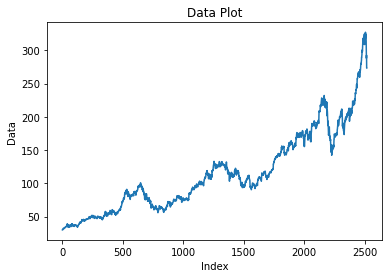

In [112]:
# Using the Matplotlib Library for visualizing our time-series data

import matplotlib.pyplot as plt

plt.title("Data Plot")
plt.xlabel("Index")
plt.ylabel("Data")
plt.plot(df1)

In [113]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[6.72575693e-05],
       [0.00000000e+00],
       [2.30693463e-04],
       ...,
       [8.83812549e-01],
       [8.19480684e-01],
       [8.18942624e-01]])

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df1, test_size=0.20, shuffle=False)

In [115]:
X_train_data = []
Y_train_data = []
X_test_data = []
Y_test_data = []

train_len = len(X_train)
test_len = len(X_test)

# Create the training dataset
for i in range(train_len-101):
    a = X_train[i:(i+100), 0]
    X_train_data.append(a)
    Y_train_data.append(X_train[i + 100, 0])

# Create the test dataset
for j in range(test_len-101):
    b = X_test[j:(j+100), 0]
    X_test_data.append(a)
    Y_test_data.append(X_test[j + 100, 0])
    
X_train_data = np.array(X_train_data)
Y_train_data = np.array(Y_train_data)
X_test_data = np.array(X_test_data)
Y_test_data = np.array(Y_test_data)

In [116]:
### Converting the training and testing data shapes into a 3-dimensional space to make it suitable for LSTMs

X_train_data = X_train_data.reshape(1913, 100, 1)
X_test_data = X_test_data.reshape(403, 100, 1)

print(X_train_data.shape)
print(X_test_data.shape)

(1913, 100, 1)
(403, 100, 1)


In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Build The Architecture

model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))

In [118]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 100)          40800     
                                                                 
 lstm_13 (LSTM)              (None, 100, 100)          80400     
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [119]:
# Initializing the callbacks

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("checkpoint1.h5", monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto')

logdir='logs1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

# Model Compilation 

model.compile(loss='mean_squared_error', optimizer='adam')

In [120]:
# Training The Model

model.fit(X_train_data, 
          Y_train_data, 
          validation_data=(X_test_data, Y_test_data), 
          epochs=20, 
          batch_size=32, 
          verbose=1,
          callbacks=[checkpoint, tensorboard_Visualization])

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 0.0025
Epoch 1: val_loss improved from inf to 0.04655, saving model to checkpoint1.h5
60/60 [==============================] - 16s 202ms/step - loss: 0.0025 - val_loss: 0.0466
Epoch 2/20
60/60 [==============================] - ETA: 0s - loss: 1.8764e-04
Epoch 2: val_loss did not improve from 0.04655
60/60 [==============================] - 9s 151ms/step - loss: 1.8764e-04 - val_loss: 0.0499
Epoch 3/20
60/60 [==============================] - ETA: 0s - loss: 2.1237e-04
Epoch 3: val_loss did not improve from 0.04655
60/60 [==============================] - 8s 142ms/step - loss: 2.1237e-04 - val_loss: 0.0507
Epoch 4/20
60/60 [==============================] - ETA: 0s - loss: 1.9824e-04
Epoch 4: val_loss did not improve from 0.04655
60/60 [==============================] - 8s 135ms/step - loss: 1.9824e-04 - val_loss: 0.0525
Epoch 5/20
60/60 [==============================] - ETA: 0s - loss: 1.5908e-04
Epoch 5: val_loss di

In [121]:
train_predict = model.predict(X_train_data)
test_predict = model.predict(X_test_data)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [124]:
train_predict

array([[ 36.6338  ],
       [ 36.664932],
       [ 36.79791 ],
       ...,
       [176.35092 ],
       [178.12498 ],
       [179.38853 ]], dtype=float32)

In [127]:
Y_train = scaler.inverse_transform(Y_train_data.reshape(-1,1))

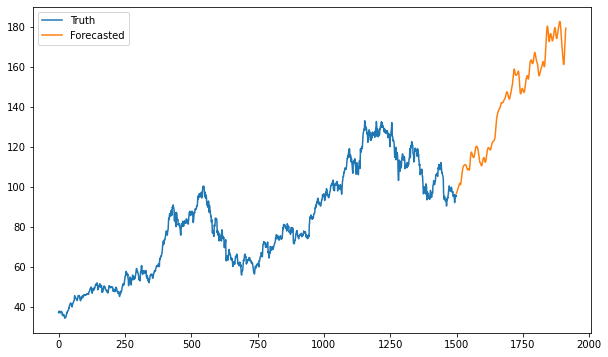

In [145]:
plt.figure(figsize=(10,6))

plt.plot(Y_train[:1500])
plt.plot(list(range(1500,len(Y_train))),train_predict[1500:])
plt.legend(['Truth','Forecasted'])

In [171]:
from sklearn.metrics import r2_score
r2_score(train_predict,Y_train)

0.99247270036597